## Code and Documentation to Decode Popup Buoy Transmitted/Recorded Data

## Software Requirements

Developed/tested for:
- python >=3.6 

requires:
- pyyaml >= 3.13 
- pandas >= 0.23.4
- numpy >= 1.15.4
- matplotlib >= 3.0.2
- jupyterlab >= 1.0.0 

In [1]:
import numpy as np
import pandas as pd
import yaml
import collections
import os
import glob

import matplotlib as mpl
import matplotlib.pyplot as plt
from matplotlib.dates import YearLocator, WeekdayLocator, MonthLocator, DayLocator, HourLocator, DateFormatter
import matplotlib.ticker as ticker
import matplotlib.dates as mdates
from matplotlib.ticker import NullFormatter  # useful for `logit` scale

import datetime
from netCDF4 import num2date, date2num
import cftime
from nc_time_axis import CalendarDateTime


## Data Structure

Data downloaded from Popup Buoy's directly, generate 8 binary files.  A complete description of these files can be found at **[link]**.  Relevant pieces will be included in the notebook.

Filenames:
- BOTDAT.TXT
- FILEPOS.TXT
- ICEDAT.TXT
- JPGxxxxx.JPG
- PRODAT.TXT
- SSTDAT.TXT
- SUMMARY.TXT

In [2]:
#INPUT year, unit serial number and test type.
year = '2021'
sn = 'M8poptop' 
test = 'bench8'

#list id's in download path
root_path = os.path.join(year, sn, test)

id_dir = os.listdir(root_path)
print(id_dir)

['.ipynb_checkpoints', 'bench8.yaml', 'BOTDAT.TXT']


In [3]:
# This is a dictionary that links a key to a value
# Here we link the raw hexadecimal files located in the root path to the names on the left of the semicolon
instfile_dic = {'bot_file': root_path +'/BOTDAT.TXT',
                'ice_file': root_path +'/ICEDAT.TXT',
                'pro_file': root_path +'/PRODAT.TXT',
                'sst_file': root_path +'/SSTDAT.TXT'}

# In order to transalate the data we need a configuration file
# This line of code points to where the .yaml configuration file is and converts it to a string
# The code will use any file located in the root path that has a '####.yaml' ending
instconfig = glob.glob(os.path.join(root_path, '*.yaml*'), recursive=False)
i_config = ''.join(map(str, instconfig))
print(i_config)

2021\M8poptop\bench8\bench8.yaml


For each data file, we are going to read in the entire file and convert the binary to hex.  There are multiple line, lengths we are going to have to address but the start of each record is denoted by 'FFFF'.  We can split the filestring on this parameter but we need to be aware of 'FFFFF' or 'FFFFFF' posibilities

***Basic Approach***

The two modules below will allow for a simple readin of the file for very simple analysis and debugging... the code of consequence that involves conversion of measurements from engineering units to science units as all defined in the PopUpBuoy CLASS in the next section

In [4]:
def HexView(file):
    with open(file, 'rb') as in_file:
        while True:
            hexdata = in_file.read().hex().upper()     # Read the shortest possible line
            if len(hexdata) == 0:                      # breaks loop once no more binary data is read
                break
            
            return(hexdata.upper())
        
def HexSplit(hexstr):
    if hexstr.find('FFFFF') == -1:
        print("No FFFFF, proceed to split on FFFF")
        sample_raw = hexstr.split('FFFF')[1:]
    else:
        print('FFFFF found')
        #this puts in the proper line endings but removes a variable 
        #   F from the end of each string.  Add the F string back
        sample_raw = []
        for substr in hexstr.split('FFFFF')[1:]: 
            sample_raw = sample_raw + (substr + 'F').split('FFFF')

        sample_raw[-1] = sample_raw[-1][:-1]
        
    return(sample_raw)

In [5]:
active_file = instfile_dic['bot_file']

hexstr = HexView(active_file)
sample_raw = HexSplit(hexstr)


No FFFFF, proceed to split on FFFF


# Class description and routine code

## Decode sample data for each file type

### Bottom Data (BOTDAT.TXT) / Under Ice Data (ICEDAT.TXT)

This data has two record lengths.  17 and 19.  Since we've split on 'FFFF' and broken the record up into samples, the initial 2bytes are no longer in the record so the record lengths are now 15 and 17 (which is a string length of 30 and 34 characters)

***MSG Decode Key***
![BotDecodeMsg](decode_images/BotDat_msg_decode.png)

***Engineering to Science Conversions***
![BotDecodeMsg](decode_images/BotDat_msg_cal.png)


### Profile Data (PRODAT.TXT) /

This data has two record lengths.  13 and 15.  Since we've split on 'FFFF' and broken the record up into samples, the initial 2bytes are no longer in the record so the record lengths are now 11 and 13 (which is a string length of 26 and 30 characters).  This file does not have the bottom temp or the reference temp fields.

***MSG Decode Key***
![ProDecodeMsg](decode_images/ProDat_msg_decode.png)

***Engineering to Science Conversions***
![ProCalMsg](decode_images/ProDat_msg_cal.png)

### SST Data (SSTDAT.TXT) /

This data has eight record lengths.  17 and 35, 18 and 36, 19 and 37 or 20 and 38.  Since we've split on 'FFFF' and broken the record up into samples, the initial 2bytes are no longer in the record so the record lengths are now 15 and 33, 16 and 34, 17 and 35 or 18 and 36.  The 8 types of files are if there is the short time format or the long time format, if TTS is provided or not, and if there is gps encoding or not for each of the time formats.

17: short-time, no gps, no TTS   
18: short-time, no gps, TTS   
19: long-time, no gps, no TTS   
20: long-time, no gps, TTS   
35: short-time, gps, no TTS   
36: short-time, gps, TTS   
37: long-time, gps, no TTS   
38: long-time, gps, TTS   

**UPDATE 3-12-2019:**  TTF is also an option now as an additional record of 2 bytes

***MSG Decode Key***
![SSTDecodeMsg](decode_images/SSTDat_msg_decode.png)

***Engineering to Science Conversions***
![SSTDecodeMsg](decode_images/SSTDat_msg_cal.png)

### Defining the PopUpBuoy Class

import functions

preload matplotlib plot paramters

In [6]:
### specify primary bulk figure parameters
fontsize = 10
labelsize = 10
#plotstyle = 'seaborn'
#max_xticks = 10
plt.style.use('seaborn-ticks')
mpl.rcParams['svg.fonttype'] = 'none'
mpl.rcParams['ps.fonttype'] = 42 #truetype/type2 fonts instead of type3
mpl.rcParams['pdf.fonttype'] = 42 #truetype/type2 fonts instead of type3
mpl.rcParams['axes.grid'] = False
mpl.rcParams['axes.edgecolor'] = 'black'
mpl.rcParams['axes.linewidth'] = 1.5
mpl.rcParams['axes.labelcolor'] = 'black'
mpl.rcParams['grid.linestyle'] = '--'
mpl.rcParams['grid.linestyle'] = '--'
mpl.rcParams['xtick.major.size'] = 4
mpl.rcParams['xtick.minor.size'] = 2
mpl.rcParams['xtick.major.width'] = 2
mpl.rcParams['xtick.minor.width'] = 0.5
mpl.rcParams['ytick.major.size'] = 4
mpl.rcParams['ytick.minor.size'] = 2
mpl.rcParams['ytick.major.width'] = 2
mpl.rcParams['ytick.minor.width'] = 0.5
mpl.rcParams['ytick.direction'] = 'out'
mpl.rcParams['xtick.direction'] = 'out'
mpl.rcParams['ytick.color'] = 'black'
mpl.rcParams['xtick.color'] = 'black'

mpl.rcParams['contour.negative_linestyle'] = 'solid'


In [7]:
def signed_int(hexstr):
    '''function to convert hex string to signed int'''
    s_int = int(hexstr,16)
    if s_int >= 0x8000:
        s_int -= 0x10000  

    return(s_int)

class PopUpBuoys(object):
    """Class definitions to read and Process PopUp Buoy Data Streams"""


    active_stream = 'bottom'
    def __init__(self, path):
        self.path = path
        self.instfile_dic = {'bottom': path + '/BOTDAT.TXT',
                             'ice': path + '/ICEDAT.TXT',
                             'profile': path + '/PRODAT.TXT',
                             'sst': path + '/SSTDAT.TXT'}
    
    def LoadCoefs(self, config_file='default.yaml'):
        ''' Load yaml formated config file '''
        self.config = yaml.safe_load(open(config_file))

    
    def HexView(self, active_stream='', verbose=True):
        '''
        input: reference to proper filepointer, options are keys 
            to the self.instfile_dic dictionary
        '''
        if active_stream:
            self.active_stream = active_stream
            
        file = self.instfile_dic[self.active_stream]
        with open(file, 'rb') as in_file:
            while True:
                hexdata = in_file.read().hex().upper()     
                if len(hexdata) == 0:                      
                # breaks loop once no more binary data is read
                    break
                self.hexstr = hexdata.upper()
                
                if verbose:
                    return(hexdata.upper())

    def HexSplit(self, verbose=True):
        '''
        input: results of HexView (inherits output)
        '''
        if self.hexstr.find('FFFFF') == -1:
            print("No FFFFF, proceed to split on FFFF")
            #because in this case the first index is empty
            sample_raw = self.hexstr.split('FFFF')[1:] 
        else:
            print('FFFFF found')
            #this puts in the proper line endings but removes a variable 
            #   F from the end of each string.  Add the F string back
            sample_raw = []
            for substr in self.hexstr.split('FFFFF'): 
                sample_raw = sample_raw + (substr + 'F').split('FFFF')

            sample_raw[-1] = sample_raw[-1][:-1]
        
        self.sample_raw = sample_raw
        
        if verbose:
            return(sample_raw)
    
    def Bottom(self, asPandas=False):
        ''' Bottom is equivalent to the TimeSeriesBase'''
        
        if self.active_stream != 'bottom':
            print("current active file is {} - can't output bottom data".format(self.active_stream))
            return

        data = self.TimeSeriesBase()

        if asPandas:
            data = pd.DataFrame.from_dict(data,orient='index')
        return(data)
    

    def Profile(self, asPandas=False):
        try:
            self.sample_raw
        except:
            print("Run PopUpBuoys.HexView and PopUpBuoys.HexSplit First")
            return

        if self.active_stream != 'profile':
            print("current active file is {} - can't output profile data".format(self.active_stream))
            return
                        
        data=collections.OrderedDict()

        for sample_num, sample in enumerate(self.sample_raw):
                        
            if len(sample) == 22: #2byte timeword
                
                # unlike sst, bottom, and ice - profiles don't need to be multiplied by a sample interval
                #seconds since 1970-01-01
                try:
                    time = int(sample[0:4],16)/100 + profile_starttime
                except:
                    time = int(sample[0:4],16)/100 + 0
                    
                pressure =  self.PressureConversion(int(sample[4:8],16)) 
                
                fr_temp_ADC = signed_int(sample[8:12])
                fr_temp = self.TempConversion(engr_meas=fr_temp_ADC,
                                                  coefA=self.config['fr_temp_cal']['Acoef'], 
                                                  coefB=self.config['fr_temp_cal']['Bcoef'],
                                                  coefC=self.config['fr_temp_cal']['Ccoef'])

                rawpvalue = signed_int(sample[12:16])                  
                par = self.PARConversion(engr_meas=rawpvalue,
                                        coef_offset=self.config['par_cal']['offset'], 
                                        coef_slope=self.config['par_cal']['slope'])   

                rawfvalue = signed_int(sample[16:20])                   
                fluor = self.FluorConversion(engr_meas=rawfvalue,
                                        coef_offset=self.config['fluor_cal']['offset'], 
                                        coef_slope=self.config['fluor_cal']['slope'])  

                tilt = int(sample[20:22],16) #degrees
                
            elif len(sample) == 26: #4byte timeword, reserved for profile starttime
                
                #seconds since 1970-01-01
                profile_starttime = int(sample[0:8],16)
                
                time = profile_starttime
                
                pressure =  self.PressureConversion(int(sample[8:12],16))  
                
                fr_temp_ADC = signed_int(sample[12:16])
                fr_temp = self.TempConversion(engr_meas=fr_temp_ADC,
                                                  coefA=self.config['fr_temp_cal']['Acoef'], 
                                                  coefB=self.config['fr_temp_cal']['Bcoef'],
                                                  coefC=self.config['fr_temp_cal']['Ccoef'])
                
                rawpvalue = signed_int(sample[16:20])             
                par = self.PARConversion(engr_meas=rawpvalue,
                                        coef_offset=self.config['par_cal']['offset'], 
                                        coef_slope=self.config['par_cal']['slope'])  

                rawfvalue = signed_int(sample[20:24])                
                fluor = self.FluorConversion(engr_meas=rawfvalue,
                                        coef_offset=self.config['fluor_cal']['offset'], 
                                        coef_slope=self.config['fluor_cal']['slope'])  

                tilt = int(sample[24:26],16) #degrees
            
            elif len(sample) == 0:
                continue
            else:
                continue # skip lines with too many data points
            #save to dictionary
            data[sample_num] = {'time':time,
                                'pressure':pressure,
                                'fr_temp':fr_temp,
                                'fr_temp_ADC':fr_temp_ADC,
                                'par':par,
                                'fluor':fluor,
                                'tilt':tilt}        
        
        if asPandas:
            data = pd.DataFrame.from_dict(data,orient='index')
        return(data)
        
    def Ice(self, asPandas=False):
        ''' Ice is equivalent to the TimeSeriesBase'''

        if self.active_stream != 'ice':
            print("current active file is {} - can't output ice data".format(self.active_stream))
            return

        data = self.TimeSeriesBase()

        if asPandas:
            data = pd.DataFrame.from_dict(data,orient='index')
        return(data)
    
    def SST(self, asPandas=False):
        ''' SST is equivalent to the TimeSeriesBase + GPS information'''
        
        if self.active_stream != 'sst':
            print("current active file is {} - can't output sst data".format(self.active_stream))
            return

        data = self.TimeSeriesBase()


        for sample_num, sample in enumerate(self.sample_raw):

            if (len(sample) == 30) or (len(sample) == 66): #2byte timeword, no TTS (w and w/o gps)
                TTS = np.nan
                if len(sample) == 66:
                    print("analyze GPS")
                    gps_data = self.GPSSeriesBase(sample_num, sample, empty=False)
                else:
                    gps_data = self.GPSSeriesBase(sample_num, sample, empty=True)

            elif (len(sample) == 32) or (len(sample) == 68): #2byte timeword, yes TTS (w and w/o gps)
                TTS = int(sample[30:32],16)
                if len(sample) == 68:
                    gps_data = self.GPSSeriesBase(sample_num, sample, offset=2, empty=False)
                else:
                    gps_data = self.GPSSeriesBase(sample_num, sample, empty=True)

            elif (len(sample) == 34) or (len(sample) == 70): #4byte timeword, no TTS (w and w/o gps)
                TTS = np.nan
                if len(sample) == 70:
                    gps_data = self.GPSSeriesBase(sample_num, sample, offset=4, empty=False)
                else:
                    gps_data = self.GPSSeriesBase(sample_num, sample, empty=True)

            elif (len(sample) == 36) or (len(sample) == 72): #4byte timeword, yes TTS (w and w/o gps)
                TTS = int(sample[30:32],16)
                if len(sample) == 72:
                    gps_data = self.GPSSeriesBase(sample_num, sample, offset=6, empty=False)
                else:
                    gps_data = self.GPSSeriesBase(sample_num, sample, empty=True)

            elif len(sample) == 0:
                continue
            else:
                continue # skip lines with too many data points
            #save to dictionary

            try:
                data[sample_num].update({'TTS':TTS})        
                data[sample_num].update(gps_data[sample_num])
            except:
                pass

        if asPandas:
            return(pd.DataFrame.from_dict(data,orient='index'))
        else:
            return(data)


    ### The folowing BASE functions are for convenience for reading and coding.  All redundant
    # pattern reads are below.  The only challenge is that each BASE function reads the entire hex
    # string (non-issue for files of size we expect)
    def GPSSeriesBase(self,sample_num, sample, offset=0, empty=True):
        '''SST only, the last 18 bytes are the same format:
         GPSLat, GPSLon, GPSDate, GPSTime, TTF, Max_Tilt
         Regardless of whether TTS or longdates are used.  This subroutine returns the 
         GPS dictionary based on a byte offset given the record length

         Passing empty=True sends missing data back for GPS Data'''
        data=collections.OrderedDict()

        if not empty:
            GPSLat = int(sample[30+offset:38+offset],16)/1000000
            GPSLon = (int(sample[38+offset:46+offset],16)- 4294967295) / 1000000
            GPSDate = int(sample[46+offset:54+offset],16)
            GPSTime = int(sample[54+offset:62+offset],16)
            TTF = int(sample[62+offset:64+offset],16)
            Max_Tilt = int(sample[62+offset:66+offset],16)   

        else:
            GPSLat = GPSLon = GPSDate = GPSTime = TTF = Max_Tilt = np.nan 
            
        #save to dictionary
        data[sample_num] = {'GPSLat':GPSLat,
                            'GPSLon':GPSLon,
                            'GPSDate':GPSDate,
                            'GPSTime':GPSTime,
                            'TTF':TTF,
                            'Max_Tilt':Max_Tilt}  
            
        return(data)   

    def TimeSeriesBase(self):
        '''Bottom, Ice, and SST all have the same base transmission information,
            e.g. the first 17 bytes (short time stamp) / 19 bytes (long time stamp)
            are the same.  Each of the the appropriate modules will call this communal module
            first.

            Bottom and Ice don't report any additional information beyond the base info so 
            they are essential decorators/wrappers for this function

            Returns: Dictionary'''
        try:
            self.sample_raw
        except:
            print("Run PopUpBuoys.HexView and PopUpBuoys.HexSplit First")
            return

        data=collections.OrderedDict()

        for sample_num, sample in enumerate(self.sample_raw):
            
            #record length conditionals are due to number of varying outputs
            #SST dominates the number of options due to:
            # 2byte timeword, no TTS, no GPS (30)
            # 4byte timeword, yes TTS, yes GPS (72)
            #  and every permutation of the three functions
            if ((len(sample) == 30) or (len(sample) == 32) or 
                            (len(sample) == 60) or (len(sample) == 64) or (len(sample) == 66) or (len(sample) == 68)) : #2byte timeword
                
                #seconds since 1970-01-01
                if self.active_stream in ['sst']:
                    #the correction is available for any non-utc setup pc
                    time_base = date2num(datetime.datetime.strptime(IDNUMBER.config['Unit_Release_Time'],
                                        '%Y-%m-%d %H:%M:%S'),
                                                                    'seconds since 1970-1-1')
                else:
                    time_base = 0 

                time = int(sample[0:4],16) * self.config['sample_interval'][self.active_stream] + time_base
                
                pressure =  self.PressureConversion(int(sample[4:8],16))  
                
                fr_temp_ADC = signed_int(sample[8:12])
                fr_temp = self.TempConversion(engr_meas=fr_temp_ADC,
                                                  coefA=self.config['fr_temp_cal']['Acoef'], 
                                                  coefB=self.config['fr_temp_cal']['Bcoef'],
                                                  coefC=self.config['fr_temp_cal']['Ccoef'])

                sr_temp_ADC = signed_int(sample[12:16])
                sr_temp = self.TempConversion(engr_meas=sr_temp_ADC,
                                                  coefA=self.config['sr_temp_cal']['Acoef'], 
                                                  coefB=self.config['sr_temp_cal']['Bcoef'],
                                                  coefC=self.config['sr_temp_cal']['Ccoef'])

                temp_ref = signed_int(sample[16:20])               
                
                rawpvalue = signed_int(sample[20:24])               
                par = self.PARConversion(engr_meas=rawpvalue,
                                        coef_offset=self.config['par_cal']['offset'], 
                                        coef_slope=self.config['par_cal']['slope']) 
                
                rawfvalue = signed_int(sample[24:28])                 
                fluor = self.FluorConversion(engr_meas=rawfvalue,
                                        coef_offset=self.config['fluor_cal']['offset'], 
                                        coef_slope=self.config['fluor_cal']['slope'])  

                tilt = int(sample[28:30],16) #degrees
                
            elif ((len(sample) == 34) or (len(sample) == 36) or (len(sample) == 72)) : #4byte timeword
                
                #seconds since 1970-01-01
                time = int(sample[0:8],16)
                
                pressure =  self.PressureConversion(int(sample[8:12],16))   
                
                fr_temp_ADC = signed_int(sample[12:16])
                fr_temp = self.TempConversion(engr_meas=fr_temp_ADC,
                                                  coefA=self.config['fr_temp_cal']['Acoef'], 
                                                  coefB=self.config['fr_temp_cal']['Bcoef'],
                                                  coefC=self.config['fr_temp_cal']['Ccoef'])

                sr_temp_ADC = signed_int(sample[16:20])
                sr_temp = self.TempConversion(engr_meas=sr_temp_ADC,
                                                  coefA=self.config['sr_temp_cal']['Acoef'], 
                                                  coefB=self.config['sr_temp_cal']['Bcoef'],
                                                  coefC=self.config['sr_temp_cal']['Ccoef'])

                temp_ref = signed_int(sample[20:24])          
                
                rawpvalue = signed_int(sample[24:28])                 
                par = self.PARConversion(engr_meas=rawpvalue,
                                        coef_offset=self.config['par_cal']['offset'], 
                                        coef_slope=self.config['par_cal']['slope'])  

                rawfvalue = signed_int(sample[28:32])               
                fluor = self.FluorConversion(engr_meas=rawfvalue,
                                        coef_offset=self.config['fluor_cal']['offset'], 
                                        coef_slope=self.config['fluor_cal']['slope'])  
                
                tilt = int(sample[32:34],16) #degrees            

            elif len(sample) == 0:
                continue
            else:
                continue # skip lines with too many data points
            #save to dictionary
            data[sample_num] = {'time':time,
                                'pressure':pressure,
                                'fr_temp':fr_temp,
                                'fr_temp_ADC':fr_temp_ADC,
                                'sr_temp':sr_temp,
                                'sr_temp_ADC':sr_temp_ADC,
                                'temp_ref':temp_ref,
                                'par':par,
                                'fluor':fluor,
                                'tilt':tilt}  
        return(data)

    @staticmethod
    def PARConversion(engr_meas,coef_offset, coef_slope):
        ''' Calculate PAR from raw measurement
        
            (ADC_val - coef_offset) * coef_slope / 0.73

            output is PAR in umolm-2s-1
        '''
        return((engr_meas - coef_offset) * coef_slope / 0.73 )

    @staticmethod
    def FluorConversion(engr_meas,coef_offset, coef_slope):
        ''' Calculate Fluometer from raw measurement

            (ADC_val - coef_offset) * coef_slope
        
            output is concentration in ug/L
        '''
        return((engr_meas - coef_offset) * coef_slope) 

    @staticmethod
    def PressureConversion(engr_meas):
        ''' Calculate Pressure from raw measurement

            (ADC_val - 16384) * 10 / 32768
        
            output is Pressure in Bars
        '''
        return((engr_meas - 16384) * 10 / 32768)

    @staticmethod
    def TempConversion(engr_meas, coefA, coefB, coefC):
        ''' Calculate Temperature from raw measurement.

        1 / ( coefA + 
              coefB*np.log(ADC_val) + 
              coefC*np.log(ADC_val)^3 ) - 273.15 

        Output is Temperature in DegC
        '''
        #if version == 1:
           #temperature = 1 / ( coefA + 
                         #coefB*np.log10(engr_meas) + 
                         #coefC*np.log10(engr_meas)**3 ) - 273.15 
        #if version == 2:
        temperature = 1 / ( coefA + 
                         coefB*np.log(engr_meas) + 
                         coefC*np.log(engr_meas)**3 ) - 273.15       

        return(temperature)          

## Sample Evaluation of routine

Imagine a buoy with serial number **xxxx**.  Instantiate a PopUpBuoys class with the relative (or absolute) path to the location of the download/reconstructed data files

In [8]:
IDNUMBER = PopUpBuoys(root_path)

Load the configuration file.  If not specified it will load a file named 'default.yaml' in the same path as the utility

In [9]:
IDNUMBER.LoadCoefs(config_file=i_config)

Call the routine to read and convert the binary file to a hex string... the sample parameter is the name of the data type.

active_stream options are:
+ bottom
+ sst
+ profile
+ ice

passing 'verbose=True' returns the hex string

### BOTTOM DATA

In [10]:
try: 
    IDNUMBER.HexView(active_stream='bottom',verbose=False)
    IDNUMBER.HexSplit(verbose=False)
    bottom_data = IDNUMBER.Bottom(asPandas=True)
    print(bottom_data)
except:
    print ('No Bottom Data') 

No FFFFF, proceed to split on FFFF
     time  pressure    fr_temp  fr_temp_ADC    sr_temp  sr_temp_ADC  temp_ref  \
0       0  0.020447  22.853302         9427  22.830587         9525      8522   
1    3600  0.019226  22.394689         9621  22.209264         9785      8522   
2    7200  0.019226  21.789351         9884  21.700111        10004      8522   
3   10800  0.018921  22.715083         9485  22.818460         9530      8522   
4   14400  0.019531  23.086619         9330  23.185412         9380      8522   
5   18000  0.019226  23.286002         9248  23.373855         9304      8522   
6   21600  0.019531  23.413476         9196  23.488753         9258      8522   
7   25200  0.019836  23.497265         9162  23.574090         9224      8522   
8   28800  0.019531  23.554145         9139  23.629496         9202      8522   
9   32400  0.018921  23.606221         9118  23.679995         9182      8522   
10  36000  0.019531  23.638526         9105  23.710353         9170      8

### PROFILE DATA

In [11]:
try:
    IDNUMBER.HexView(active_stream='profile',verbose=True)
    IDNUMBER.HexSplit(verbose=True)
    pro_data = IDNUMBER.Profile(asPandas=True)

    print(pro_data)
except:
    print('No profile data')

No profile data


### UNDER ICE DATA

In [12]:
 try:  
    IDNUMBER.HexView(active_stream='ice',verbose=False)
    IDNUMBER.HexSplit(verbose=False)
    ice_data = IDNUMBER.Ice(asPandas=True)
    print(ice_data)
except:
    print('No under ice data')

No under ice data


### SEA SURFACE DRIFTER DATA

In [13]:
try:
    IDNUMBER.HexView(active_stream='sst',verbose=True)
    IDNUMBER.HexSplit(verbose=True)
    sst_data = IDNUMBER.SST(asPandas=True)
    print(sst_data)
except:
    print('No sea surface drifter data')

No sea surface drifter data


## Convert Elapsed Time to Datetime
### Profile data spells out the profile start time which is used to create the "datetime" variable

In [14]:
#time functions are in netcdf4 library
try:
    pro_data['datetime'] =[num2date(x['time'],'seconds since 1970-1-1') for i,x in pro_data.iterrows()]
    print(pro_data['datetime'])
except:
    print('No profile data')

No profile data


### Bottom and Ice data start marking time from the "Unit_Start_Time" and "Unit_Release_Time" which are in the config file

In [15]:
print(yaml.dump(IDNUMBER.config, default_flow_style=False))

Deploy_Depth: 0
Deploy_LatN: 47.68
Deploy_LonW: -122.25
Deployment_ID: 21BSM8PopTop-TP
ENG_SN: M8poptop
IMEI: 21BS8APopTop
IMEI_SN: M8poptop
Unit_Deploy_Time: '2021-08-04 22:00:00'
Unit_Release_Time: '2022-05-05 00:00:00'
Unit_Start_Time: '2021-08-04 23:00:00'
fluor_cal:
  offset: 0
  slope: 0
fr_temp_cal:
  Acoef: 0.00119592366
  Bcoef: 0.000229076131
  Ccoef: 1.12298413e-07
par_cal:
  offset: 0
  slope: 0
sample_interval:
  bottom: 3600
  ice: 3600
  sst: 3600
sr_temp_cal:
  Acoef: 0.00121860374
  Bcoef: 0.000221753083
  Ccoef: 1.66927166e-07
version: 2



In [16]:
try:
    bottom_data['datetime'] =[num2date(x['time'],'seconds since '+ (IDNUMBER.config['Unit_Start_Time'])) for i, x in bottom_data.iterrows()]
    print(bottom_data['datetime'])
except:
    print('No bottom data')

0     2021-08-04 23:00:00
1     2021-08-05 00:00:00
2     2021-08-05 01:00:00
3     2021-08-05 02:00:00
4     2021-08-05 03:00:00
5     2021-08-05 04:00:00
6     2021-08-05 05:00:00
7     2021-08-05 06:00:00
8     2021-08-05 07:00:00
9     2021-08-05 08:00:00
10    2021-08-05 09:00:00
11    2021-08-05 10:00:00
12    2021-08-05 11:00:00
13    2021-08-05 12:00:00
14    2021-08-05 13:00:00
15    2021-08-05 14:00:00
16    2021-08-05 15:00:00
17    2021-08-05 16:00:00
18    2021-08-05 17:00:00
19    2021-08-05 18:00:00
20    2021-08-05 19:00:00
21    2021-08-05 20:00:00
Name: datetime, dtype: object


#### Trim out deck data using deploy date in config file for output csv files

In [17]:
#bottom_data = bottom_data.drop(bottom_data[bottom_data['datetime'] < IDNUMBER.config['Unit_Start_Time']].index)

In [18]:
try:
    ice_data['datetime'] =[num2date(x['time'],'seconds since '+ str(IDNUMBER.config['Unit_Release_Time']) ) for i,x in ice_data.iterrows()]
    print(ice_data['datetime'])
except:
    print('No under ice data')

No under ice data


In [19]:
try:
    sst_data['datetime'] =[num2date(x['time'],'seconds since 1970-1-1') for i,x in sst_data.iterrows()]
    print(sst_data['datetime'])
except:
    print("No sea surface drifter data")   
#filter out any dates that are before the deployment date
#sst_data = sst_data[sst_data.datetime>IDNUMBER.config['Unit_Start_Time']]

No sea surface drifter data


## **Saving Data to be used in other software**
#### *simple as sending the pandas dataframe to csv*

In [20]:
#add columnes depth_m and id, lat, lon from config to datafiles
try:
    ice_data['depth_m'] = ice_data.pressure*9.931170631574
    ice_data['id'] = IDNUMBER.config['IMEI_SN']
    ice_data['dep_lat'] = IDNUMBER.config['Deploy_LatN']
    ice_data['dep_lon'] = IDNUMBER.config['Deploy_LonW']
    ice_data.to_csv(os.path.join(root_path, sn +'_ice_data.csv'))
except:
    print("No under ice data")
try:
    sst_data['depth_m'] = sst_data.pressure*9.931170631574
    sst_data['id'] = IDNUMBER.config['IMEI_SN']
    sst_data['dep_lat'] = IDNUMBER.config['Deploy_LatN']
    sst_data['dep_lon'] = IDNUMBER.config['Deploy_LonW']
    sst_data.to_csv(os.path.join(root_path, sn +'_sst_data.csv'))
except:
    print("No sea surface drifter data")
try:
    bottom_data['depth_m'] = bottom_data.pressure*9.931170631574
    bottom_data['id'] = IDNUMBER.config['IMEI_SN']
    bottom_data['dep_lat'] = IDNUMBER.config['Deploy_LatN']
    bottom_data['dep_lon'] = IDNUMBER.config['Deploy_LonW']
    bottom_data.to_csv(os.path.join(root_path, sn +'_bottom_data.csv'))
except:
    print("No bottom data")  
try:
    pro_data['depth_m'] = pro_data.pressure*9.931170631574
    pro_data['id'] = IDNUMBER.config['IMEI_SN']
    pro_data['dep_lat'] = IDNUMBER.config['Deploy_LatN']
    pro_data['dep_lon'] = IDNUMBER.config['Deploy_LonW']
    pro_data.to_csv(os.path.join(root_path, sn +'_profile_data.csv'))
except:
    print("No profile data")

No under ice data
No sea surface drifter data
No profile data


# PLOTTING FUN
#### Since a pandas dataframe is a native output, quicklook plots are very easy to obtain as are output to csv for other software

## Profile Plot

no profile data


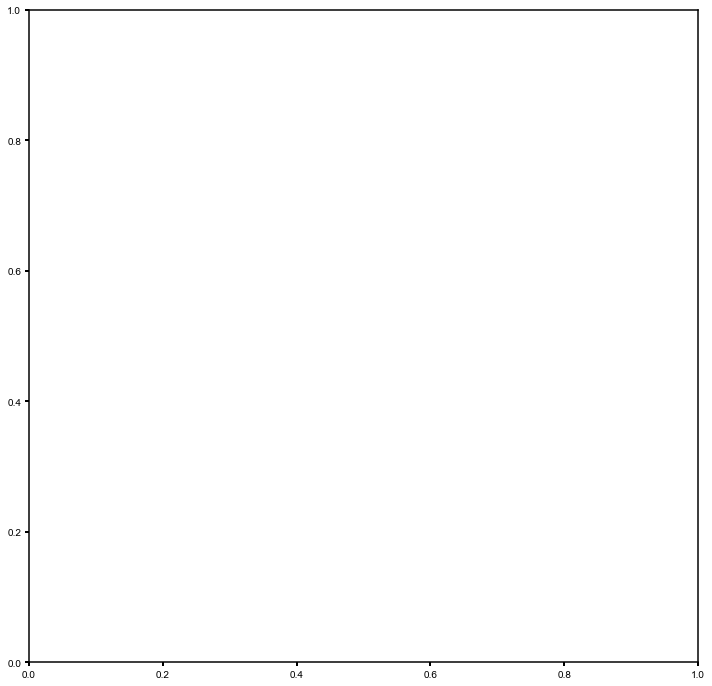

In [21]:
#%matplotlib inline
try:
    fig = plt.figure(figsize=(12, 12))
    ax1 = plt.subplot(1, 1, 1)
    pd.plotting.scatter_matrix(pro_data, ax=ax1)
    fig.savefig(os.path.join(root_path, sn+'_profile_data.facetgrid.png'), dpi=300, tight_layout=True)

except:
    print('no profile data')

No profile data


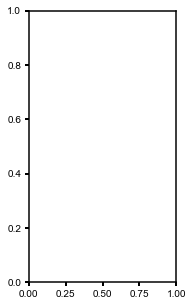

In [22]:
try: 
    fig = plt.figure(1,figsize=(9,5))
    ### CTD Temperature
    ax1 = plt.subplot(1, 3, 1)
    plt.plot(pro_data.fr_temp,pro_data.pressure*10,'r',linewidth=.5)
    ax1.invert_yaxis()
    ax1.set_xlabel('Temperature')
    ax1.set_ylabel('Depth (m)')
    ### CTD PAR
    ax1 = plt.subplot(1, 3, 2)
    plt.plot(pro_data.par,pro_data.pressure*10,'y',linewidth=.5)
    ax1.invert_yaxis()
    ax1.set_xlabel('PAR')
    ### CTD Temperature
    ax1 = plt.subplot(1, 3, 3)
    plt.plot(pro_data.fluor,pro_data.pressure*10,'g',linewidth=.5)
    ax1.invert_yaxis()
    ax1.set_xlabel('Chlor')

    fig.savefig(os.path.join(root_path, sn+'_pro_data.simple.png'),dpi=300)
    
except:
    print('No profile data')

### Timeseries Plots of Bottom Data

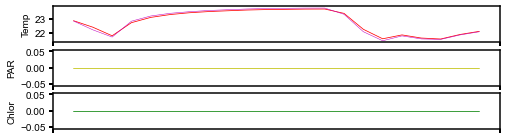

In [23]:
fig = plt.figure(1,figsize=(8,2.5))
### CTD Temperature
ax1a = plt.subplot(3, 1, 1)
plt.plot(bottom_data.datetime,bottom_data.fr_temp,'r',linewidth=.75)
plt.plot(bottom_data.datetime,bottom_data.sr_temp,'m',linewidth=.5)
ax1a.set_xticklabels([])
ax1a.set_ylabel('Temp')
### Par
ax1b = plt.subplot(3, 1, 2)
plt.plot(bottom_data.datetime,bottom_data.par,'y',linewidth=.75)
ax1b.set_xticklabels([])
ax1b.set_ylabel('PAR')
### Chlor
ax1c = plt.subplot(3, 1, 3)
plt.plot(bottom_data.datetime,bottom_data.fluor,'g',linewidth=.75)
ax1c.set_ylabel('Chlor')


## specify datelabels and ticks for all three pannels
ax1a.yaxis.set_minor_locator(ticker.MultipleLocator(1))
ax1a.xaxis.set_major_locator(DayLocator(bymonthday=1))
ax1a.xaxis.set_minor_locator(DayLocator(bymonthday=15))
#ax1b.yaxis.set_minor_locator(ticker.MultipleLocator(2.5))
ax1b.xaxis.set_major_locator(DayLocator(bymonthday=1))
ax1b.xaxis.set_minor_locator(DayLocator(bymonthday=15))

ax1c.tick_params(labelbottom=True,labeltop=False)
#ax1c.yaxis.set_minor_locator(ticker.MultipleLocator(2.5))
ax1c.xaxis.set_major_locator(DayLocator(bymonthday=1))
ax1c.xaxis.set_minor_locator(DayLocator(bymonthday=15))
ax1c.xaxis.set_major_formatter(ticker.NullFormatter())
ax1c.xaxis.set_minor_formatter(DateFormatter('%b %y'))
ax1c.xaxis.set_major_formatter(DateFormatter(''))
ax1c.xaxis.set_tick_params(which='major', pad=15)
ax1c.xaxis.set_tick_params(which='minor', pad=5)

fig.subplots_adjust(bottom=0.2)
fig.savefig(os.path.join(root_path, sn+'_bottom_data.png'),dpi=300)

### Timeseries Plots of Under Ice Data

NameError: name 'ice_data' is not defined

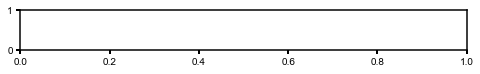

In [24]:
fig = plt.figure(1,figsize=(8,2.5))
### CTD Temperature
ax1a = plt.subplot(3, 1, 1)
plt.plot(ice_data.datetime,ice_data.fr_temp,'r',linewidth=.75)
plt.plot(ice_data.datetime,ice_data.sr_temp,'m',linewidth=.5)
ax1a.set_xticklabels([])
ax1a.set_ylabel('Temp')
### Par
ax1b = plt.subplot(3, 1, 2)
plt.plot(ice_data.datetime,ice_data.par,'y',linewidth=.75)
ax1b.set_xticklabels([])
ax1b.set_ylabel('PAR')
### Chlor
ax1c = plt.subplot(3, 1, 3)
plt.plot(ice_data.datetime,ice_data.fluor,'g',linewidth=.75)
ax1c.set_ylabel('Chlor')

## specify datelabels and ticks for all three pannels
ax1a.yaxis.set_minor_locator(ticker.MultipleLocator(2.5))
ax1a.xaxis.set_major_locator(DayLocator(bymonthday=1))
ax1a.xaxis.set_minor_locator(DayLocator(bymonthday=15))
ax1b.yaxis.set_minor_locator(ticker.MultipleLocator(2.5))
ax1b.xaxis.set_major_locator(DayLocator(bymonthday=1))
ax1b.xaxis.set_minor_locator(DayLocator(bymonthday=15))

ax1c.tick_params(labelbottom=True,labeltop=False)
ax1c.yaxis.set_minor_locator(ticker.MultipleLocator(2.5))
ax1c.xaxis.set_major_locator(DayLocator(bymonthday=1))
ax1c.xaxis.set_minor_locator(DayLocator(bymonthday=15))
ax1c.xaxis.set_major_formatter(ticker.NullFormatter())
ax1c.xaxis.set_minor_formatter(DateFormatter('%b %y'))
ax1c.xaxis.set_major_formatter(DateFormatter(''))
ax1c.xaxis.set_tick_params(which='major', pad=15)
ax1c.xaxis.set_tick_params(which='minor', pad=5)

fig.subplots_adjust(bottom=0.2)
fig.savefig(os.path.join(root_path, sn+'_chlor_ice_data.png'),dpi=300)

### Time Series Plots of Sea Surface Drifter Data

In [ ]:
try:
    fig = plt.figure(1,figsize=(8,2.5))
    ### CTD Temperature
    ax1a = plt.subplot(3, 1, 1)
    plt.plot(sst_data.datetime,sst_data.fr_temp,'r.',markersize=.5,linewidth=.75)
    plt.plot(sst_data.datetime,sst_data.sr_temp,'m.',markersize=.5,linewidth=.5)
    ax1a.set_xticklabels([])
    ax1a.set_ylabel('Temp')
    ### Par
    ax1b = plt.subplot(3, 1, 2)
    plt.plot(sst_data.datetime,sst_data.par,'y.',markersize=.5,linewidth=.75)
    ax1b.set_xticklabels([])
    ax1b.set_ylabel('PAR')
    ### Chlor
    ax1c = plt.subplot(3, 1, 3)
    plt.plot(sst_data.datetime,sst_data.fluor,'g.',markersize=.5,linewidth=.75)
    ax1c.set_ylabel('Chlor')


    ## specify datelabels and ticks for all three pannels
    ax1a.yaxis.set_minor_locator(ticker.MultipleLocator(2.5))
    ax1a.xaxis.set_major_locator(DayLocator(bymonthday=1))
    ax1a.xaxis.set_minor_locator(DayLocator(bymonthday=15))
    ax1b.yaxis.set_minor_locator(ticker.MultipleLocator(2.5))
    ax1b.xaxis.set_major_locator(DayLocator(bymonthday=1))
    ax1b.xaxis.set_minor_locator(DayLocator(bymonthday=15))

    ax1c.tick_params(labelbottom=True,labeltop=False)
    ax1c.yaxis.set_minor_locator(ticker.MultipleLocator(2.5))
    ax1c.xaxis.set_major_locator(DayLocator(bymonthday=1))
    ax1c.xaxis.set_minor_locator(DayLocator(bymonthday=15))
    ax1c.xaxis.set_major_formatter(ticker.NullFormatter())
    ax1c.xaxis.set_minor_formatter(DateFormatter('%b %y'))
    ax1c.xaxis.set_major_formatter(DateFormatter(''))
    ax1c.xaxis.set_tick_params(which='major', pad=15)
    ax1c.xaxis.set_tick_params(which='minor', pad=5)

    fig.savefig(os.path.join(root_path, sn+'_sst_data.png'),dpi=300)
except:
    print("No SST Data yet")